In [11]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf

In [12]:
from sklearn.cross_validation import train_test_split

In [13]:
import edward as ed

In [14]:
from edward.models import Categorical, Dirichlet, InverseGamma, Normal
from edward.models import Categorical, Dirichlet, InverseGamma, Mixture, \
    MultivariateNormalDiag, Normal

In [15]:
def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x

N = 5000  # number of data points
D = 2  # dimensionality of data

X = build_toy_dataset(N)

In [16]:
X_train, X_test = train_test_split(X,test_size=.9)

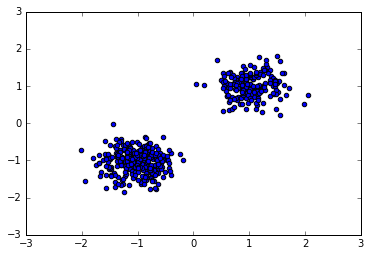

In [17]:
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()

In [18]:
N = X_train.shape[0]
N_test = X_test.shape[0]

In [20]:
K = 2  # number of components

mu = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
sigma = InverseGamma(alpha=tf.ones([K, D]), beta=tf.ones([K, D]))
cat = Categorical(logits=tf.zeros([N, K]))
components = [
    MultivariateNormalDiag(mu=tf.ones([N, 1]) * tf.gather(mu, k),
                           diag_stdev=tf.ones([N, 1]) * tf.gather(sigma, k))
    for k in range(K)]
x = Mixture(cat=cat, components=components)

In [21]:
qmu = Normal(
    mu=tf.Variable(tf.random_normal([K, D])),
    sigma=tf.nn.softplus(tf.Variable(tf.zeros([K, D]))))
qsigma = InverseGamma(
    alpha=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))),
    beta=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))))

In [22]:
inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={x: X_train})
inference.run(n_iter=5000, n_samples=20)

Iteration    1 [  0%]: Loss = 3461.348
Iteration  500 [ 10%]: Loss = 1682.520
Iteration 1000 [ 20%]: Loss = 1155.428
Iteration 1500 [ 30%]: Loss = 1022.091
Iteration 2000 [ 40%]: Loss = 828.480
Iteration 2500 [ 50%]: Loss = 839.496
Iteration 3000 [ 60%]: Loss = 792.440
Iteration 3500 [ 70%]: Loss = 767.755
Iteration 4000 [ 80%]: Loss = 804.919
Iteration 4500 [ 90%]: Loss = 798.437
Iteration 5000 [100%]: Loss = 831.077


In [23]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post = Normal(mu=tf.ones([N, 1, 1, 1]) * mu_sample,
                sigma=tf.ones([N, 1, 1, 1]) * sigma_sample)
x_broadcasted = tf.tile(tf.reshape(X_train, [N, 1, 1, D]), [1, 100, K, 1])

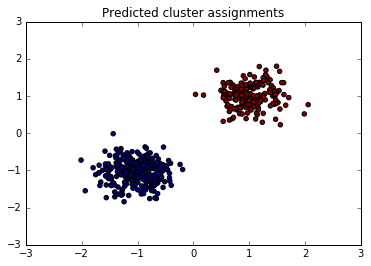

In [24]:
# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
clusters = tf.argmax(log_liks, 1).eval()
plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters)#, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [25]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post_pred = Normal(mu=tf.ones([N_test, 1, 1, 1]) * mu_sample,
                sigma=tf.ones([N_test, 1, 1, 1]) * sigma_sample)
x_broadcasted_pred = tf.tile(tf.reshape(X_test, [N_test, 1, 1, D]), [1, 100, K, 1])

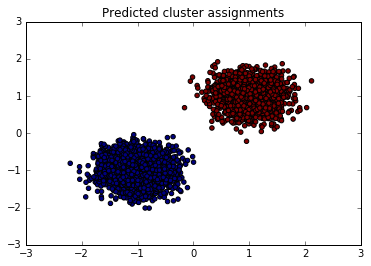

In [26]:
# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post_pred.log_prob(x_broadcasted_pred)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
clusters = tf.argmax(log_liks, 1).eval()
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters)#, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [27]:
log_liks.shape

TensorShape([Dimension(4500), Dimension(2)])

In [28]:
tf.reduce_max(log_liks, 1).eval().sum()

-4152.4932

In [29]:
np.max(log_liks.eval(),1).sum()

-4166.0625